In [1]:
### INITIALIZATION ###
import pandas as pd
import numpy as np
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from ggplot import *

C:\Anaconda\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Anaconda\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
creditcard = pd.read_csv('creditcard.csv')
print(creditcard.head())
print("Dataset contains numerical input variables V1 to V28, which are the result of a PCA transformation of the original features")

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

In [3]:
### PLOTTING FUNCTIONS ###

def plot1(df):
    plot1 = ggplot(aes(x = "Class"), data=df) + geom_bar() + ggtitle("Plot1 - Highly imbalanced Class problem") + labs(y = "Count", x ="Class")
    return print(plot1)

def plot2(df):
    plot2 = ggplot(aes(x = "day"), data = df) + geom_bar() + labs(y = "Count", x = "Day") + ggtitle("Plot2 - Transactions per day")
    return print(plot2)

def plot3(df):
    plot3 = ggplot(aes(x = "Time_bin"), data = df) + geom_bar() + facet_wrap("Class", scales="free", ncol=2) + labs(y = "Count", x = "Time_bin") + ggtitle("Plot3 - Fraud cases distribution by Time_bin") 
    return print(plot3)

def plot4(df):
    plot4 = ggplot(aes(x = "Amount"), data = df) + geom_histogram() + facet_wrap("Class", scales = "free", ncol = 2) + labs(y = "Count", x = "Amount") + ggtitle("Plot4 - Fraud cases distribution by Amount")
    return(print(plot4))

def plot5(df):
    plot5 = ggplot(aes(x = "DF.L2.C1", y = "DF.L2.C2", color = "Class"), data = df) + geom_point(alpha = 0.1) + ggtitle("Plot5 - Dimensionality reduced layer 2 features class dependency")
    return print(plot5)

# def plot6(df):
#     plot6 = ggplot(aes(y = "Reconstruction.MSE", color = "Class"), data = df) + gem_point(alpha = 0.3) + geom_hline(data = mean_mse, aes())
#     return print(plot6)

# def plot7(df):
#     plot7 = ggplot(aes=(), data = df) + 
#     return print(plot7)

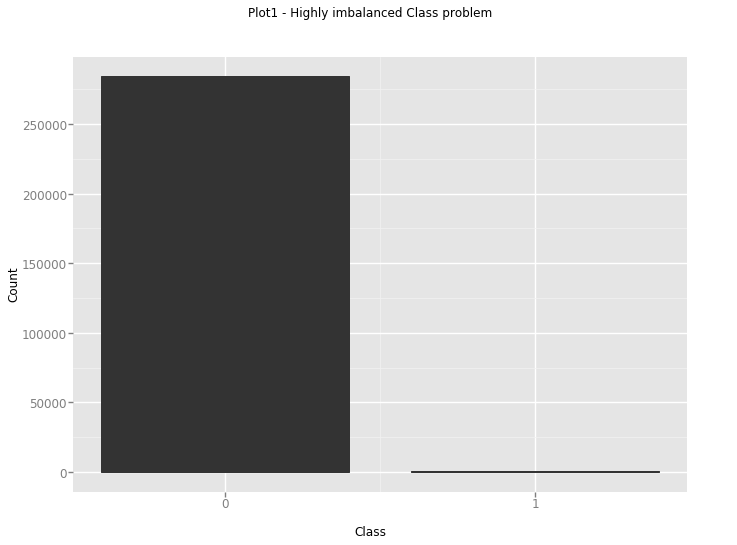

<ggplot: (77320694136)>
Plot1 shows the severe imbalance in fraud cases in the dataset - This imbalance is to be taken care of in all the analysis
 process below


In [4]:
### DATA EXPLORATION AND FEATURE ENGG. ###
plot1(creditcard)
print("Plot1 shows the severe imbalance in fraud cases in the dataset - This imbalance is to be taken care of in all the analysis\n process below")

In [5]:
# Time only tells us the order in which transactions have been done, it doesn’t actually tell us anything about the actual times (i.e. time of day) of the transaction. Therefore, normalize them by day and bin them into four groups according to time of day.
print("Time variable summary\n", creditcard['Time'].describe())
creditcard['day'] = np.where(creditcard['Time'] < 86400, 'day1', 'day2')
creditcard['Time_day'] = np.where(creditcard['day'] == 'day2', creditcard['Time'] - (3600*24), creditcard['Time'])
print('Day1 time\n', creditcard['Time_day'].loc[creditcard['day'] == 'day1'].describe())
print('Day2 time\n', creditcard['Time_day'].loc[creditcard['day'] == 'day2'].describe())

Time variable summary
 count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64
Day1 time
 count    144786.000000
mean      52947.673435
std       21349.674538
min           0.000000
25%       38432.000000
50%       54689.000000
75%       70976.000000
max       86398.000000
Name: Time_day, dtype: float64
Day2 time
 count    140021.000000
mean      51704.777555
std       20715.506616
min           0.000000
25%       37842.000000
50%       53425.000000
75%       68182.000000
max       86392.000000
Name: Time_day, dtype: float64


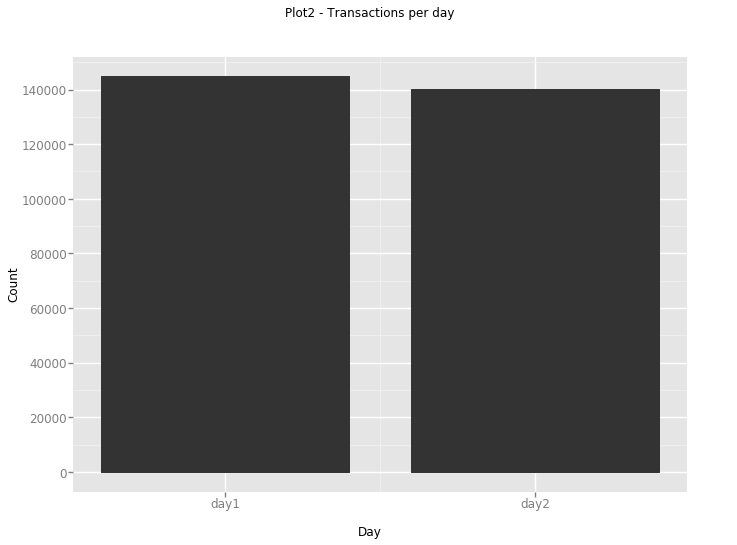

<ggplot: (77321067398)>
Plot showing nearly the same number of transaction per day


In [6]:
plot2(creditcard)
print("Plot showing nearly the same number of transaction per day")

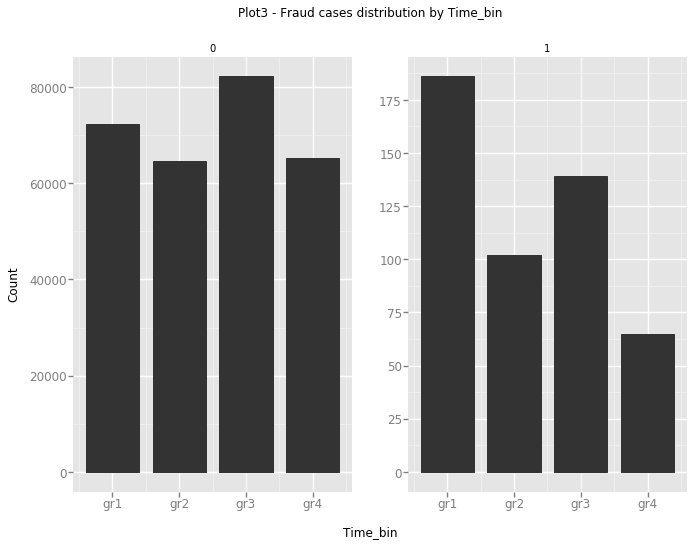

<ggplot: (77325973519)>
The distribution of transactions over the four Time_bin shows that majority of fraud cases have happened in group1


In [7]:
# Bin transactions according to time of day
bins = [-1, 38432, 52947, 70976, 86398]
bin_label = ['gr1', 'gr2', 'gr3', 'gr4']
creditcard['Time_bin'] = pd.cut(creditcard['Time_day'], bins=bins, labels=bin_label)
plot3(creditcard)
print("The distribution of transactions over the four Time_bin shows that majority of fraud cases have happened in group1")

Class0 transaction amount stats
 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
Class1(Fraud) transaction amount stats
 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


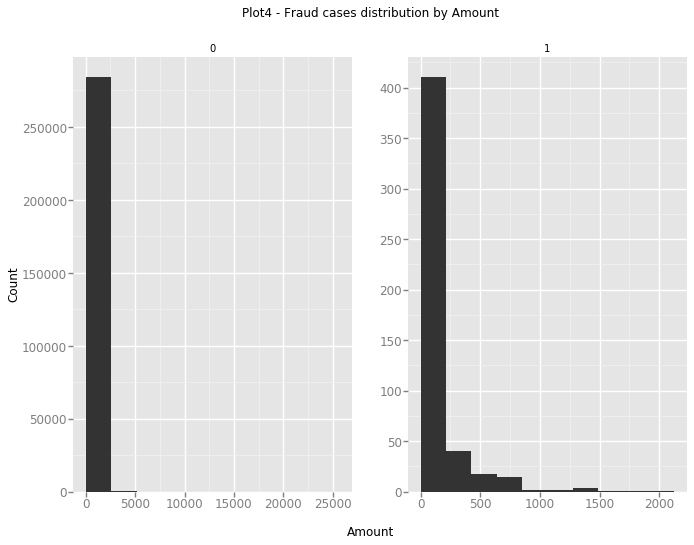

<ggplot: (77321144980)>
Fraudulent transactions had a higher mean amount of money that was transferred, but the maximum amount was much lower compared to regular transactions


In [8]:
# ANALYZING TRANSACTIONS BY THE AMOUNT TRANSFERRED
print('Class0 transaction amount stats\n',creditcard['Amount'].loc[creditcard['Class'] == 0].describe())
print('Class1(Fraud) transaction amount stats\n',creditcard['Amount'].loc[creditcard['Class'] == 1].describe())
plot4(creditcard)
print("Fraudulent transactions had a higher mean amount of money that was transferred, but the maximum amount was much lower compared to regular transactions")

In [11]:
### MODELING ###

## FEATURE LEARNING USING AUTOENCODERS ##
prox = {"202.141.80.24":"3128"}
h2o.init(nthreads = -1, proxy = prox, username = "vishal.bharti", password = "pSpEKZ8m")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 mins 54 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,7 months and 6 days !!!
H2O cluster name:,H2O_from_python_The_Extreme_1tiiia
H2O cluster total nodes:,1
H2O cluster free memory:,1.748 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [12]:
# CONVERT DATA TO H2O FRAME AND SPLIT INTO train_supervised, train_unsupervised, test
credit_hf = h2o.H2OFrame(creditcard)
train_unsupervised, train_supervised, test = credit_hf.split_frame(ratios = [0.4,0.4], seed = 100)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
# # FIT AUTOENCODER TO train_unsupervised
# model_autoencoder = H2OAutoEncoderEstimator(activation = 'tanh', hidden = [10, 2, 10], epochs = 100, ignore_const_cols=False, seed = 100, model_id = "model_autoencoder")
# model_autoencoder.fit(train_unsupervised.drop(['Class'], axis = 1))
# model_autoencoder_path = h2o.save_model(model=model_autoencoder, path="/Data Science and Analytics/Projects/Anomaly Detection in Credit card transactions/Model_files/model_autoencoder", force=True)

In [14]:
model_autoencoder = h2o.load_model(path = "/Data Science and Analytics/Projects/Anomaly Detection in Credit card transactions/Model_files/model_autoencoder/model_autoencoder")
model_autoencoder

Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  model_autoencoder


ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.0030260081792912105
RMSE: 0.055009164502755455
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
,2018-09-02 23:30:59,0.208 sec,0.00000 obs/sec,0.0,0,0.0,0.2581211,0.0666265
,2018-09-02 23:31:04,5.761 sec,90284 obs/sec,4.3809482,5,499542.0,0.1906832,0.0363601
,2018-09-02 23:31:10,11.355 sec,90016 obs/sec,8.7658780,10,999538.0,0.0659172,0.0043451
,2018-09-02 23:31:15,16.948 sec,89948 obs/sec,13.1523249,15,1499707.0,0.0761549,0.0057996
,2018-09-02 23:31:21,22.428 sec,90355 obs/sec,17.5376055,20,1999743.0,0.1675053,0.0280580
,2018-09-02 23:31:27,28.276 sec,89416 obs/sec,21.9247715,25,2499994.0,0.0651693,0.0042470
,2018-09-02 23:31:32,33.809 sec,89635 obs/sec,26.3114290,30,3000187.0,0.1633426,0.0266808
,2018-09-02 23:31:38,39.361 sec,89791 obs/sec,30.6938330,35,3499895.0,0.0550092,0.0030260
,2018-09-02 23:31:43,44.929 sec,89839 obs/sec,35.0804816,40,4000087.0,0.1416908,0.0200763
,2018-09-02 23:31:49,50.421 sec,90014 obs/sec,39.4671742,45,4500284.0,0.1488438,0.0221545


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Time_bin.gr4,1.0,1.0,0.1707998
Time_bin.gr2,0.8910607,0.8910607,0.1521930
Time_bin.gr3,0.7084035,0.7084035,0.1209952
day.day2,0.6186260,0.6186260,0.1056612
day.day1,0.6029841,0.6029841,0.1029896
---,---,---,---
V1,0.0082692,0.0082692,0.0014124
V18,0.0073623,0.0073623,0.0012575
V22,0.0072937,0.0072937,0.0012458
Time_bin.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [15]:
# CONVERT TEST TO AUTOENCODED REPRESENTATION
test_autoenc = model_autoencoder.predict(test)
test_autoenc.head()

deeplearning prediction progress: |███████████████████████████████████████| 100%


reconstr_Time_bin.gr1,reconstr_Time_bin.gr2,reconstr_Time_bin.gr3,reconstr_Time_bin.gr4,reconstr_Time_bin.missing(NA),reconstr_day.day1,reconstr_day.day2,reconstr_day.missing(NA),reconstr_Time,reconstr_V1,reconstr_V2,reconstr_V3,reconstr_V4,reconstr_V5,reconstr_V6,reconstr_V7,reconstr_V8,reconstr_V9,reconstr_V10,reconstr_V11,reconstr_V12,reconstr_V13,reconstr_V14,reconstr_V15,reconstr_V16,reconstr_V17,reconstr_V18,reconstr_V19,reconstr_V20,reconstr_V21,reconstr_V22,reconstr_V23,reconstr_V24,reconstr_V25,reconstr_V26,reconstr_V27,reconstr_V28,reconstr_Amount,reconstr_Time_day
0.99991,0.0765394,0.0260299,0.126828,0.000547888,0.999995,-0.0360239,0.00160896,-3952.06,-1.39497,0.146621,0.432584,-0.435132,0.370134,1.86584,0.399217,-0.0371681,-0.309368,0.349145,0.271125,-0.358936,-0.052912,-0.162629,0.363514,-0.292463,0.208048,-0.236434,-0.709712,-0.259682,-0.106707,-0.160849,-0.0150322,-0.141474,-0.0180856,0.0581084,0.00495667,-0.218134,257.82,-7197.71
0.999911,0.0758273,0.0267194,0.125228,0.00054824,0.999995,-0.0353004,0.00160996,-3984.99,-1.39549,0.146735,0.4322,-0.435319,0.370771,1.86694,0.399162,-0.0373025,-0.309195,0.349408,0.271171,-0.359288,-0.0527749,-0.162698,0.363052,-0.292445,0.20822,-0.236562,-0.709767,-0.259576,-0.106706,-0.160933,-0.0148216,-0.141345,-0.0180361,0.0582317,0.00494786,-0.218223,257.902,-7231.61
0.999911,0.0762708,0.0263192,0.126167,0.000548029,0.999995,-0.0357293,0.00160937,-3965.15,-1.39517,0.14667,0.432435,-0.435208,0.370384,1.86625,0.399193,-0.0372159,-0.3093,0.349247,0.271141,-0.359077,-0.0528584,-0.162655,0.363327,-0.29245,0.208109,-0.236485,-0.709735,-0.259645,-0.106706,-0.160882,-0.0149491,-0.141421,-0.0180642,0.0581577,0.00495755,-0.218166,257.849,-7211.3
0.999911,0.0758978,0.0266434,0.125401,0.000548203,0.999995,-0.0353776,0.00160985,-3981.56,-1.39544,0.146722,0.432239,-0.435299,0.370705,1.86683,0.399168,-0.0372899,-0.309213,0.349381,0.271167,-0.359251,-0.052789,-0.162691,0.363101,-0.292448,0.208204,-0.236549,-0.709761,-0.259585,-0.106707,-0.160924,-0.0148434,-0.141359,-0.0180417,0.0582188,0.00494765,-0.218214,257.895,-7228.05
0.99991,0.0764539,0.0260799,0.126699,0.000547921,0.999995,-0.0359609,0.00160905,-3955.28,-1.39503,0.146627,0.432542,-0.435149,0.3702,1.86597,0.399214,-0.0371874,-0.30935,0.349173,0.271132,-0.358969,-0.0528977,-0.162638,0.363473,-0.292468,0.208072,-0.236446,-0.709716,-0.259666,-0.106708,-0.160857,-0.015011,-0.141463,-0.0180827,0.05812,0.00495095,-0.218145,257.832,-7200.9
0.99991,0.0765786,0.0259134,0.127068,0.000547846,0.999995,-0.0361215,0.00160882,-3948.47,-1.39494,0.146596,0.432616,-0.435107,0.370072,1.86577,0.399228,-0.0371683,-0.309385,0.349123,0.271126,-0.358894,-0.0529247,-0.162626,0.363575,-0.29248,0.208046,-0.236419,-0.709703,-0.259679,-0.10671,-0.160841,-0.0150537,-0.141493,-0.0180957,0.058094,0.00494592,-0.218132,257.821,-7193.72
0.999911,0.0761404,0.0264168,0.125929,0.000548086,0.999995,-0.0356177,0.00160952,-3970.54,-1.39526,0.146685,0.432369,-0.435237,0.370491,1.86645,0.399186,-0.0372433,-0.309271,0.349292,0.271151,-0.359133,-0.0528351,-0.162668,0.363255,-0.292453,0.208144,-0.236506,-0.709743,-0.259623,-0.106707,-0.160896,-0.0149141,-0.141401,-0.0180578,0.0581776,0.00495185,-0.218183,257.866,-7216.74
0.999911,0.0763762,0.0261415,0.12655,0.000547955,0.999995,-0.0358919,0.00160914,-3958.57,-1.39509,0.146636,0.432502,-0.435166,0.370264,1.86609,0.399209,-0.0372033,-0.309333,0.349201,0.271138,-0.359004,-0.0528836,-0.162645,0.363429,-0.292468,0.208092,-0.236459,-0.709721,-0.259652,-0.106709,-0.160866,-0.0149898,-0.141451,-0.0180785,0.0581322,0.00494806,-0.218156,257.842,-7204.24
0.99991,0.0765385,0.0259435,0.126995,0.000547863,0.999995,-0.036087,0.00160887,-3950.14,-1.39497,0.146601,0.432596,-0.435116,0.370105,1.86583,0.399226,-0.0371767,-0.309376,0.349137,0.271129,-0.358912,-0.0529175,-0.16263,0.363552,-0.292481,0.208057,-0.236426,-0.709706,-0.259672,-0.106711,-0.160845,-0.0150429,-0.141487,-0.0180937,0.0581001,0.0049442,-0.218137,257.826,-7195.4
0.999911,0.0759086,0

deepfeatures progress: |██████████████████████████████████████████████████| 100%


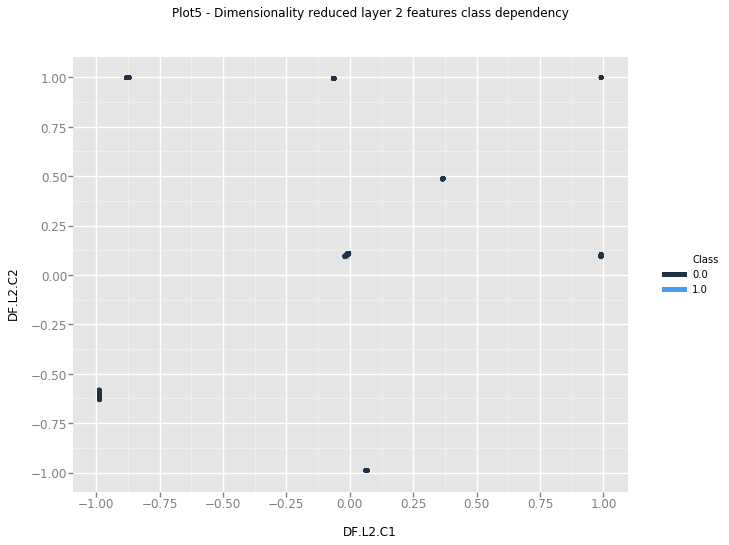

<ggplot: (77322906614)>
Here we do not see segregable fraud and non-fraud clusters, so dimensionality reduction with autoencoder model alone
 is not sufficient to identify fraud cases.


In [16]:
## DIMENSIONALITY REDUCTION WITH AUTOENCODERS - USING THE SECOND LAYER OF model_autoencoder TO SPOT FRAUD CASES ##
train_features_L2 = model_autoencoder.deepfeatures(train_unsupervised, 1)
train_features_L2['Class'] = train_unsupervised['Class']
plot5(train_features_L2.as_data_frame())
print("Here we do not see segregable fraud and non-fraud clusters, so dimensionality reduction with autoencoder model alone\n is not sufficient to identify fraud cases.")

In [17]:
## DIMENSIONALITY REDUCTION WITH AUTOENCODERS - USING THE LAST HIDDEN LAYER OF model_autoencoder AS FEATURES FOR MODEL TRAINING ##
train_features_L3 = model_autoencoder.deepfeatures(train_unsupervised, 2)

# # TRAINING CLASSIFICATION MODEL ON FEATURES LEARNED BY model_autoencoder
# model_autoencoder_dim = H2ODeepLearningEstimator(activation = 'tanh', hidden = [10, 2, 10], epochs = 100, ignore_const_cols=False, balance_classes = True, seed = 100, model_id = "model_autoencoder_dim")
# model_autoencoder_dim.fit(x = train_features_L3, y = train_unsupervised['Class'].asfactor())
# model_autoencoder_dim_path = h2o.save_model(model=model_autoencoder_dim, path="/Data Science and Analytics/Projects/Anomaly Detection in Credit card transactions/Model_files/model_autoencoder_dim", force=True)

deepfeatures progress: |██████████████████████████████████████████████████| 100%


In [18]:
model_autoencoder_dim = h2o.load_model(path = "/Data Science and Analytics/Projects/Anomaly Detection in Credit card transactions/Model_files/model_autoencoder_dim/model_autoencoder_dim")
model_autoencoder_dim

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  model_autoencoder_dim


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.4002208672345835
RMSE: 0.6326301188171359
LogLoss: 1.815699847529939
Mean Per-Class Error: 0.47321965591518766
AUC: 0.47988625742844393
Gini: -0.04022748514311214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00038116227214083205: 


,0,1,Error,Rate
0,361.0,4550.0,0.9265,(4550.0/4911.0)
1,180.0,4883.0,0.0356,(180.0/5063.0)
Total,541.0,9433.0,0.4742,(4730.0/9974.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0003812,0.6737031,395.0
max f2,0.0002864,0.8375240,399.0
max f0point5,0.0010298,0.5732515,387.0
max accuracy,0.0010298,0.5330860,387.0
max precision,0.5835161,1.0,0.0
max recall,0.0002864,1.0,399.0
max specificity,0.5835161,1.0,0.0
max absolute_mcc,0.1870526,0.1247303,365.0
max min_per_class_accuracy,0.1871187,0.4519060,362.0
max mean_per_class_accuracy,0.0010298,0.5267803,387.0


Gains/Lift Table: Avg response rate: 50.76 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0112292,0.5795369,1.4950728,1.4950728,0.7589286,0.7589286,0.0167885,0.0167885,49.5072797,49.5072797
,2,0.0231602,0.5686915,0.9767119,1.2280384,0.4957983,0.6233766,0.0116532,0.0284416,-2.3288083,22.8038404
,3,0.0300782,0.5656986,1.4560709,1.2804859,0.7391304,0.65,0.0100731,0.0385147,45.6070898,28.0485878
,4,0.0400040,0.5511097,0.6367607,1.1207646,0.3232323,0.5689223,0.0063204,0.0448351,-36.3239346,12.0764582
,5,0.0500301,0.5374921,0.0,0.8961625,0.0,0.4549098,0.0,0.0448351,-100.0,-10.3837539
,6,0.1006617,0.4545923,0.5968449,0.7456093,0.3029703,0.3784861,0.0302192,0.0750543,-40.3155097,-25.4390693
,7,0.1499900,0.4545894,1.3893952,0.9573357,0.7052846,0.4859626,0.0685364,0.1435908,38.9395246,-4.2664301
,8,0.2005214,0.4545868,1.2820494,1.0391635,0.6507937,0.5275,0.0647837,0.2083745,28.2049353,3.9163539
,9,0.2999799,0.2430030,0.8400210,0.9731377,0.4264113,0.4939840,0.0835473,0.2919218,-15.9979022,-2.6862337
,10,0.4024464,0.1917778,0.9367998,0.9638857,0.4755382,0.4892875,0.0959905,0.3879123,-6.3200156,-3.6114268



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-09-03 00:31:29,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan
,2018-09-03 00:31:29,0.659 sec,242951 obs/sec,0.4385615,1,99853.0,0.7114082,3.3566827,0.5661748,1.8085046,0.4809505
,2018-09-03 00:31:34,5.811 sec,271464 obs/sec,6.5874088,15,1499841.0,0.7110318,3.2927580,0.5164584,1.0440885,0.4444556
,2018-09-03 00:31:40,11.242 sec,279418 obs/sec,13.1767018,30,3000111.0,0.7104293,3.2521828,0.5941124,0.6894924,0.4823541
,2018-09-03 00:31:45,16.155 sec,282076 obs/sec,19.3355279,44,4402371.0,0.6326301,1.8156998,0.4798863,1.4950728,0.4742330
,2018-09-03 00:31:50,21.373 sec,283962 obs/sec,25.9289670,59,5903585.0,0.7102027,3.0872807,0.5345871,1.9699783,0.4808502
,2018-09-03 00:31:55,26.487 sec,286185 obs/sec,32.5109033,74,7402180.0,0.7073403,2.8752515,0.5336022,0.0,0.4697213
,2018-09-03 00:32:00,31.797 sec,289133 obs/sec,39.5470501,90,9004191.0,0.7106886,3.2941358,0.5958021,1.7047889,0.4923802
,2018-09-03 00:32:05,36.804 sec,290891 obs/sec,46.1397557,105,10505238.0000000,0.7074938,2.8357622,0.5129364,0.0,0.4923802
,2018-09-03 00:32:11,42.107 sec,292551 obs/sec,53.1643864,121,12104627.0000000,0.7095850,3.0027002,0.5274265,1.4008734,0.4570884


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
DF.L3.C1,1.0,1.0,0.1578733
DF.L3.C10,0.9577419,0.9577419,0.1512018
DF.L3.C9,0.7587241,0.7587241,0.1197823
DF.L3.C7,0.6573048,0.6573048,0.1037709
DF.L3.C3,0.6095209,0.6095209,0.0962271
DF.L3.C2,0.5580209,0.5580209,0.0880966
DF.L3.C6,0.5186540,0.5186540,0.0818816
DF.L3.C5,0.4524022,0.4524022,0.0714222
DF.L3.C4,0.4304408,0.4304408,0.0679551
DF.L3.C8,0.3913847,0.3913847,0.0617892


In [19]:
test_features_L3 = model_autoencoder.deepfeatures(test, 2)
test_autoenc_dim = model_autoencoder_dim.predict(test_features_L3)

test_autoenc_dim_df = test_autoenc_dim.as_data_frame()
test_df = test.as_data_frame()
test_df["Class_predict_autoencoder_dim"] = test_autoenc_dim_df["predict"]
print(test_df.groupby(["Class", "Class_predict_autoencoder_dim"]).Class.count())
print("80/(80+3) = 96.4% of the fraud cases were identified correctly but it also mis-classified lots of other non fraud transactions")

deepfeatures progress: |██████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Class  Class_predict_autoencoder_dim
0      0                                 4635
       1                                52011
1      0                                    3
       1                                   80
Name: Class, dtype: int64
80/(80+3) = 96.4% of the fraud cases were identified correctly but it also mis-classified lots of other non fraud transactions


In [20]:
## ANOMALY DETECTION BY SETTING THRESHOLD ON RECONSTRUCTED MSE ##
anomaly = model_autoencoder.anomaly(test)
anomaly_df = anomaly.as_data_frame()
anomaly_df["Class"] = (test.as_data_frame())["Class"]
anomaly_df.head()

,Reconstruction.MSE,Class
0,0.001513,0
1,0.001775,0
2,0.001466,0
3,0.001737,0
4,0.002086,0


In [21]:
mean_mse = anomaly_df.groupby("Class")

In [22]:
# ### PLOTING FUNCTIONS IN R - GGPLOT2
# import rpy2.robjects as robj
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri

# utils = importr('utils')
# utils.install_packages('tidyverse')

# gr = importr('grDevices')
# robj.pandas2ri.activate()

# r_plot1 = robj.r("""
#     function(creditcard){
#     library(tidyverse)
    
#     p = creditcard %>% ggplot(aes(x = Class)) + geom_bar(color = "grey", fill = "lightgrey") + theme_bw()
#     print(p)
#     }
#     """)

# # r_plot2 = robj.r("""
# #     function(creditcard){
# #     library(ggplot2)
# #     library(tidyverse)
# #     libraray(dplyr)
    
# #     p = creditcard %>% ggplot(aes(x = Class)) + geom_bar(color = "grey", fill = "lightgrey") + theme_bw()
# #     print(p)
# #     }
# #     """)
# creditcard_R = robj.conversion.py2ri(creditcard)

# r_plot1(creditcard_R)

In [23]:
# import rpy2.ipython

# %reload_ext rpy2.ipython

# # We need ggplot2

# %R require(ggplot2)
# %R library("ggplot2")
# # Load in the pandas library
# import pandas as pd 
# # Make a pandas DataFrame
# df = pd.DataFrame({'Alphabet': ['a', 'b', 'c', 'd','e', 'f', 'g', 'h','i'],
#                    'A': [4, 3, 5, 2, 1, 7, 7, 5, 9],
#                    'B': [0, 4, 3, 6, 7, 10,11, 9, 13],
#                    'C': [1, 2, 3, 1, 2, 3, 1, 2, 3]})
# # Take the name of input variable df and assign it to an R variable of the same name
# %R -i df
# # Plot the DataFrame df
# %R print(ggplot(data=df) + geom_point(aes(x=A, y=B, color=C)))

In [24]:
# ##USING THE PRE TRAINED AUTOENCODER TO DETECT ANOMALY
# model_pre = H2ODeepLearningEstimator(pretrained_autoencoder = model_autoencoder, balance_classes = True, ignore_const_cols = False, hidden = [10, 2 , 10], epochs = 100, activation = "tanh")
# model_pre.fit(x = train_supervised.drop(['Class'], axis = 1), y = train_supervised['Class'].asfactor())
# model_pre_path = h2o.save_model(model=model_pre, path="/Data Science and Analytics/Projects/Anomaly Detection in Credit card transactions/Model_files/model_pretrained_autoencoder")

In [25]:
# ##USING THE PRE TRAINED AUTOENCODER TO DETECT ANOMALY - CROSS VALIDATED
# model_pre = H2ODeepLearningEstimator(pretrained_autoencoder = model_autoencoder, balance_classes = True, ignore_const_cols = False, hidden = [10, 2 , 10], epochs = 100, activation = "tanh")
# model_pre.fit(x = train_supervised.drop(['Class'], axis = 1), y = train_supervised['Class'].asfactor())
# model_pre_path = h2o.save_model(model=model_pre, path="/Data Science and Analytics/Projects/Anomaly Detection in Credit card transactions/Model_files/model_pretrained_autoencoder")

In [26]:
model_pre = h2o.load_model(path = "/Data Science and Analytics/Projects/Anomaly Detection in Credit card transactions/Model_files/model_pretrained_autoencoder/DeepLearning_model_python_1535806794663_47")
model_pre

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1535806794663_47


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.000897111222127962
RMSE: 0.02995181500557123
LogLoss: 0.006492061844087719
Mean Per-Class Error: 0.0005842259006816342
AUC: 0.9996150208445662
Gini: 0.9992300416891324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9760141457817489: 


,0,1,Error,Rate
0,5129.0,6.0,0.0012,(6.0/5135.0)
1,0.0,4885.0,0.0,(0.0/4885.0)
Total,5129.0,4891.0,0.0006,(6.0/10020.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.9760141,0.9993863,97.0
max f2,0.9760141,0.9997544,97.0
max f0point5,0.9760141,0.9990184,97.0
max accuracy,0.9760141,0.9994012,97.0
max precision,0.9998693,1.0,0.0
max recall,0.9760141,1.0,97.0
max specificity,0.9998693,1.0,0.0
max absolute_mcc,0.9760141,0.9988024,97.0
max min_per_class_accuracy,0.9760141,0.9988315,97.0
max mean_per_class_accuracy,0.9760141,0.9994158,97.0


Gains/Lift Table: Avg response rate: 48.75 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0113772,0.9998653,2.0511771,2.0511771,1.0,1.0,0.0233367,0.0233367,105.1177073,105.1177073
,2,0.0204591,0.9998648,2.0511771,2.0511771,1.0,1.0,0.0186285,0.0419652,105.1177073,105.1177073
,3,0.0300399,0.9998647,2.0511771,2.0511771,1.0,1.0,0.0196520,0.0616172,105.1177073,105.1177073
,4,0.0410180,0.9998646,2.0511771,2.0511771,1.0,1.0,0.0225179,0.0841351,105.1177073,105.1177073
,5,0.0511976,0.9998646,2.0511771,2.0511771,1.0,1.0,0.0208802,0.1050154,105.1177073,105.1177073
,6,0.1031936,0.9998645,2.0511771,2.0511771,1.0,1.0,0.1066530,0.2116684,105.1177073,105.1177073
,7,0.1849301,0.9998645,2.0486726,2.0500701,0.9987790,0.9994603,0.1674514,0.3791198,104.8672583,105.0070123
,8,0.2008982,0.9998645,2.0511771,2.0501581,1.0,0.9995032,0.0327533,0.4118731,105.1177073,105.0158107
,9,0.3033932,0.9998326,2.0491798,2.0498276,0.9990263,0.9993421,0.2100307,0.6219038,104.9179821,104.9827614
,10,0.4021956,0.9888160,2.0470333,2.0491412,0.9979798,0.9990074,0.2022518,0.8241556,104.7033281,104.9141165



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-09-01 19:51:54,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan
,2018-09-01 19:51:55,1.043 sec,174148 obs/sec,0.4388604,1,99961.0,0.3201244,0.7656015,0.9811531,2.0511771,0.0626747
,2018-09-01 19:52:00,6.300 sec,190300 obs/sec,4.8299191,11,1100130.0,0.2640035,0.4796118,0.9958633,2.0511771,0.0158683
,2018-09-01 19:52:06,11.539 sec,191462 obs/sec,9.2186553,21,2099770.0,0.2338073,0.3683801,0.9990101,2.0511771,0.0054890
,2018-09-01 19:52:11,16.679 sec,193497 obs/sec,13.6092486,31,3099833.0,0.2003840,0.2096449,0.9991930,2.0511771,0.0043912
---,---,---,---,---,---,---,---,---,---,---,---
,2018-09-01 19:53:13,1 min 19.029 sec,206099 obs/sec,70.2627209,160,16004021.0000000,0.0293962,0.0071084,0.9996137,2.0511771,0.0005988
,2018-09-01 19:53:18,1 min 24.014 sec,205902 obs/sec,74.6575158,170,17005041.0000000,0.0299518,0.0064921,0.9996150,2.0511771,0.0005988
,2018-09-01 19:53:23,1 min 29.382 sec,206016 obs/sec,79.4902096,181,18105803.0000000,0.0324336,0.0075042,0.9996016,2.0511771,0.0007984
,2018-09-01 19:53:29,1 min 34.755 sec,207119 obs/sec,84.7568511,193,19305407.0000000,0.0364126,0.0098749,0.9995174,2.0511771,0.0009980



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Amount,1.0,1.0,0.0711992
V2,0.6755271,0.6755271,0.0480970
V5,0.5436718,0.5436718,0.0387090
V11,0.5329760,0.5329760,0.0379475
V24,0.5059683,0.5059683,0.0360246
---,---,---,---
V18,0.2562667,0.2562667,0.0182460
V13,0.2502379,0.2502379,0.0178167
Time,0.2006440,0.2006440,0.0142857
V28,0.1856339,0.1856339,0.0132170



See the whole table with table.as_data_frame()


In [27]:
pred = model_pre.predict(test)
pred_df = pred.as_data_frame()

test_df["Class_predict_autoencoder_pre"] = pred_df["predict"]
print(test_df.groupby(["Class", "Class_predict_autoencoder_pre"]).Class.count())

deeplearning prediction progress: |███████████████████████████████████████| 100%
Class  Class_predict_autoencoder_pre
0      0                                56590
       1                                   56
1      0                                   17
       1                                   66
Name: Class, dtype: int64
